In [1]:
import os
import torch
import matplotlib.pyplot as plt

def show(tensor_path):
    steps = 50  # 假设有50个step
    channels = 16  # 假设有16个channel
    t_group_size = 3  # 每 3 个 T 进行分组
    
    # 存储最终的均值和标准差
    mean_values = torch.zeros(steps)
    std_values = torch.zeros(steps)
    
    for i in range(steps):
        # 加载 noise_pred 数据
        noise_pred = torch.load(f"/home/siyuan/HunyuanVideo_efficiency/results/{tensor_path}/noise_pred_{i}.pt")[0, :, :, :, :]
        
        batch_size, num_channels, num_timesteps, height, width = noise_pred.shape
        
        num_t_groups = (num_timesteps + t_group_size - 1) // t_group_size  # 计算 T 需要多少个分组
        
        group_means = []
        group_stds = []
        
        # 遍历 T 维度，每 3 个 T 作为一组
        for t_group in range(num_t_groups):
            t_start = t_group * t_group_size
            t_end = min((t_group + 1) * t_group_size, num_timesteps)  # 确保不会超出 T 维度
            
            # 计算每个channel的均值和标准差
            group_mean = noise_pred[:, :, t_start:t_end, :, :].mean(dim=[2, 3, 4])  # (B, C)
            group_std = noise_pred[:, :, t_start:t_end, :, :].std(dim=[2, 3, 4])  # (B, C)
            
            group_means.append(group_mean)
            group_stds.append(group_std)
        
        # 转换为张量并计算所有 channel 的均值
        group_means = torch.stack(group_means).mean()  # 计算所有 channel 均值的均值
        group_stds = torch.stack(group_stds).mean()    # 计算所有 channel 标准差的均值
        
        mean_values[i] = group_means
        std_values[i] = group_stds
    
    # 绘制最终图表
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 绘制均值变化
    axes[0].plot(range(steps), mean_values, marker='x', linestyle='-', label='Mean over all Channels')
    axes[0].set_title('Mean of Noise Prediction')
    axes[0].set_xlabel('Step (i)')
    axes[0].set_ylabel('Mean')
    
    # 绘制标准差变化
    axes[1].plot(range(steps), std_values, marker='x', linestyle='-', label='Standard Deviation over all Channels')
    axes[1].set_title('Standard Deviation of Noise Prediction')
    axes[1].set_xlabel('Step (i)')
    axes[1].set_ylabel('Standard Deviation')
    
    plt.show()


In [ ]:
show("tensor")

/tmp/ipykernel_261110/656071405.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noise_pred = torch.load(file_path)


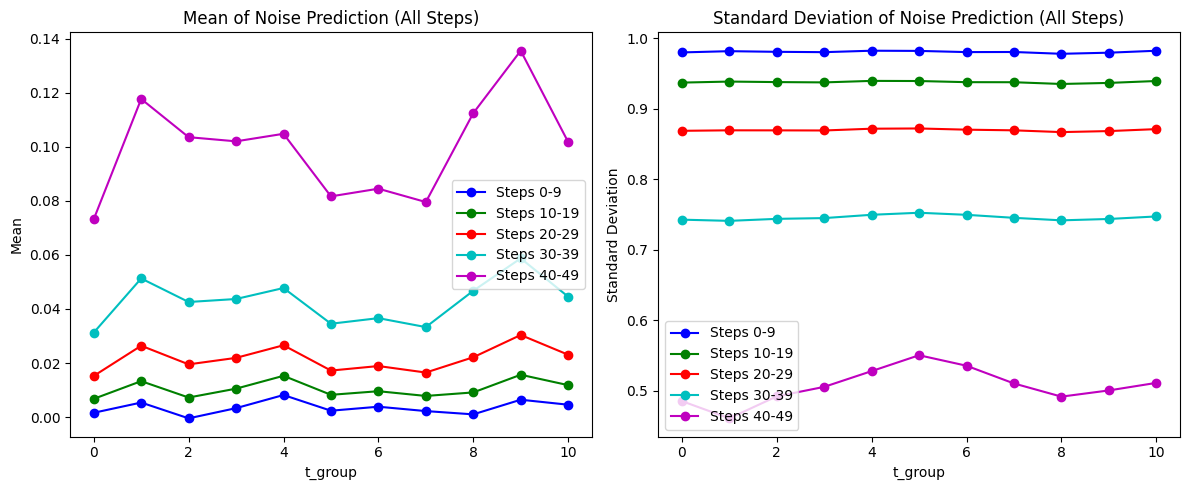

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def show(tensor_path):
    steps = 50  # 假设有 50 个 step
    t_group_size = 3  # 每 3 个 T 进行分组
    step_interval = 10  # 每 10 个 step 计算一次均值，但最后一起画
    num_plots = steps // step_interval  # 总共有多少次计算（5 组）

    all_means_plot = []  # 存储 5 组均值
    all_stds_plot = []   # 存储 5 组标准差
    step_labels = []  # 存储 5 组 step 名称（0-9, 10-19, ...）

    for i in range(num_plots):  # 遍历 5 组数据
        step_start = i * step_interval
        step_end = step_start + step_interval - 1

        all_means = []
        all_stds = []
        
        for step in range(step_start, step_end + 1):
            file_path = f"{tensor_path}/latents_{step}.pt"
            if not os.path.exists(file_path):
                print(f"跳过 Step {step}，文件 {file_path} 不存在")
                continue
            
            noise_pred = torch.load(file_path)
            if noise_pred.ndim != 5:
                print(f"跳过 Step {step}，noise_pred 维度异常: {noise_pred.shape}")
                continue
            
            batch_size, num_channels, num_timesteps, height, width = noise_pred.shape
            num_t_groups = (num_timesteps + t_group_size - 1) // t_group_size 

            group_means = []
            group_stds = []

            for t_group in range(num_t_groups):
                t_start = t_group * t_group_size
                t_end = min((t_group + 1) * t_group_size, num_timesteps)

                group_mean = noise_pred[:, :, t_start:t_end, :, :].mean(dim=[2, 3, 4])  # (B, C)
                group_std = noise_pred[:, :, t_start:t_end, :, :].std(dim=[2, 3, 4])  # (B, C)
                group_means.append(group_mean)
                group_stds.append(group_std)
            
            group_means_avg = torch.stack(group_means).mean(dim=[1, 2])  # (num_t_groups,)
            group_stds_avg = torch.stack(group_stds).mean(dim=[1, 2])  # (num_t_groups,)

            all_means.append(group_means_avg.cpu().numpy())
            all_stds.append(group_stds_avg.cpu().numpy())

        # 计算 10 个 steps 内的均值
        if all_means:  # 避免空数据错误
            mean_plot = np.mean(np.array(all_means), axis=0)
            std_plot = np.mean(np.array(all_stds), axis=0)
            all_means_plot.append(mean_plot)
            all_stds_plot.append(std_plot)
            step_labels.append(f"Steps {step_start}-{step_end}")

    # ---------------- 绘制在同一张图上 ---------------- #
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    colors = ['b', 'g', 'r', 'c', 'm']  # 5 组数据不同颜色

    for idx, (mean, std, label) in enumerate(zip(all_means_plot, all_stds_plot, step_labels)):
        color = colors[idx % len(colors)]
        num_t_groups = len(mean)

        axes[0].plot(range(num_t_groups), mean, marker='o', linestyle='-', color=color, label=label)
        axes[1].plot(range(num_t_groups), std, marker='o', linestyle='-', color=color, label=label)

    # 设置图例
    axes[0].set_title("Mean of Noise Prediction (All Steps)")
    axes[0].set_xlabel("t_group")
    axes[0].set_ylabel("Mean")
    axes[0].legend()

    axes[1].set_title("Standard Deviation of Noise Prediction (All Steps)")
    axes[1].set_xlabel("t_group")
    axes[1].set_ylabel("Standard Deviation")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

show("results/idea_0/tensor")



[INFO] 处理第 0 组: steps 0 ~ 9 ...

[INFO] 处理第 1 组: steps 10 ~ 19 ...


/tmp/ipykernel_261110/853721198.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noise_pred = torch.load(file_path)  # (B, C, T, H, W)



[INFO] 处理第 2 组: steps 20 ~ 29 ...

[INFO] 处理第 3 组: steps 30 ~ 39 ...

[INFO] 处理第 4 组: steps 40 ~ 49 ...


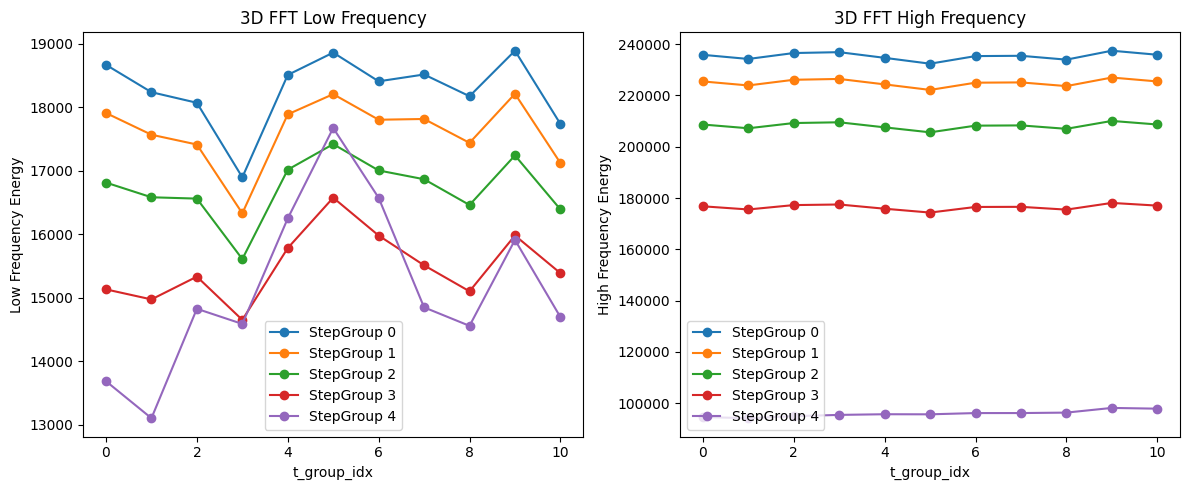

In [30]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def analyze_low_high_freq_3d(tensor_3d, cutoff_ratio=0.9):
    """
    对形状为 (T, H, W) 的 3D 张量做 3D FFT，
    按球形半径区分低频区域与高频区域，并分别返回它们的幅度之和。
    """
    freq = torch.fft.fftn(tensor_3d, dim=(0,1,2))       # 对 (T,H,W) 做 3D FFT
    freq_shifted = torch.fft.fftshift(freq, dim=(0,1,2)) # 将零频移到中心

    magnitude = torch.abs(freq_shifted)
    T, H, W = tensor_3d.shape
    center_t, center_h, center_w = T // 2, H // 2, W // 2

    # 计算球形半径阈值
    max_radius = np.sqrt(center_t**2 + center_h**2 + center_w**2)
    cutoff = cutoff_ratio * max_radius

    # 构造网格并计算到中心的距离
    tt, hh, ww = torch.meshgrid(
        torch.arange(T), torch.arange(H), torch.arange(W), indexing='ij'
    )
    rr = torch.sqrt((tt - center_t)**2 + (hh - center_h)**2 + (ww - center_w)**2)

    low_mask = (rr <= cutoff)
    high_mask = (rr > cutoff)

    low_freq_energy = magnitude[low_mask].sum().item()
    high_freq_energy = magnitude[high_mask].sum().item()
    return low_freq_energy, high_freq_energy


def show_3d_freq_analysis(tensor_path, 
                          steps=50, 
                          t_group_size=3, 
                          step_interval=10, 
                          cutoff_ratio=0.2):
    """
    目标可视化:
      - 将 `steps=50` 分成若干 step group (每组10个step, 共5组).
      - 在每个 step group 内，对这10个step的 (B, C, T, H, W) 数据进行切分(t_group_size)，计算3D FFT能量再做平均。
      - 收集所有组的结果, 形成 (num_groups, num_t_groups) 数组.
      - 横轴: t_group_idx (0..num_t_groups-1)
      - 每条线: 对应一个 step group
    """

    # 一共多少组 (假设 50 / 10 = 5)
    num_groups = steps // step_interval  

    # 用于存放各组在每个 t_group_idx 的 (低频 / 高频) 平均能量
    # 最终会是 shape = (num_groups, num_t_groups)
    group_lf_list = []
    group_hf_list = []

    # 用来记录所有组使用的 num_t_groups, 需要确保一致
    global_num_t_groups = None

    # ---- 遍历 5 个 step group ----
    for group_idx in range(num_groups):
        step_start = group_idx * step_interval
        step_end   = step_start + step_interval - 1

        print(f"\n[INFO] 处理第 {group_idx} 组: steps {step_start} ~ {step_end} ...")

        # 临时收集本组内(10个 step)在每个 t_group_idx 下的能量值
        # lf_by_tgroup[t] 会存放该组的多个 step 在 t_group=t 的 low freq
        lf_by_tgroup = None
        hf_by_tgroup = None
        num_t_groups = None  # 当前组内的 t_group 数

        valid_step_count = 0

        # ---- 遍历该组内 10 个 step ----
        for step in range(step_start, step_end + 1):
            file_path = os.path.join(tensor_path, f"latents_{step}.pt")
            if not os.path.exists(file_path):
                print(f"  [跳过] Step {step}, 文件不存在: {file_path}")
                continue

            noise_pred = torch.load(file_path)  # (B, C, T, H, W)
            if noise_pred.ndim != 5:
                print(f"  [跳过] Step {step}, 维度异常: {noise_pred.shape}")
                continue

            B, C, T, H, W = noise_pred.shape
            current_num_t_groups = (T + t_group_size - 1) // t_group_size

            # 若还未初始化本组的 num_t_groups => 用当前 step 的 T 进行初始化
            if num_t_groups is None:
                num_t_groups = current_num_t_groups
                lf_by_tgroup = [[] for _ in range(num_t_groups)]
                hf_by_tgroup = [[] for _ in range(num_t_groups)]
            else:
                # 如果本组里出现了不同的 T => 这里做简单跳过
                if current_num_t_groups != num_t_groups:
                    print(f"  [警告] Step {step} T与本组其他step不一致 => 跳过")
                    continue

            # 分段
            for t_group_idx in range(num_t_groups):
                t_start = t_group_idx * t_group_size
                t_end_  = min((t_group_idx + 1)*t_group_size, T)

                # 先对 (B, C) 做平均 => (t_len, H, W)
                group_data = noise_pred[:, :, t_start:t_end_, :, :].mean(dim=(0,1))

                # 计算 3D FFT 低频 / 高频
                lf_val, hf_val = analyze_low_high_freq_3d(group_data, cutoff_ratio)
                lf_by_tgroup[t_group_idx].append(lf_val)
                hf_by_tgroup[t_group_idx].append(hf_val)

            valid_step_count += 1

        # ---- 统计本组的均值 (对step做平均)----
        # 如果本组没有任何合法文件, 做个空处理
        if not num_t_groups or valid_step_count == 0:
            print(f"  [跳过] 第 {group_idx} 组 => 无有效 step")
            group_lf_list.append([])
            group_hf_list.append([])
            continue

        lf_group_avg = []
        hf_group_avg = []
        for t_group_idx in range(num_t_groups):
            # 收集了本组内(若干step)在 t_group_idx 下的能量
            lf_vals = lf_by_tgroup[t_group_idx]
            hf_vals = hf_by_tgroup[t_group_idx]
            if len(lf_vals) > 0:
                lf_group_avg.append(np.mean(lf_vals))
                hf_group_avg.append(np.mean(hf_vals))
            else:
                # 没有任何 step => 置0
                lf_group_avg.append(0.0)
                hf_group_avg.append(0.0)

        group_lf_list.append(lf_group_avg)
        group_hf_list.append(hf_group_avg)

        # 若全局还未确定 num_t_groups, 则赋值
        if global_num_t_groups is None:
            global_num_t_groups = num_t_groups
        else:
            # 若遇到本组与前面组不一致 => 这里简单提示
            if num_t_groups != global_num_t_groups:
                print(f"[警告] 第{group_idx}组的 num_t_groups={num_t_groups}, 与之前不一致({global_num_t_groups})")

    # -- 把 5 组的数据做成 (num_groups, global_num_t_groups) 数组 --
    num_groups = len(group_lf_list)  # 实际处理了多少组(通常就是5)
    if not num_groups or global_num_t_groups is None:
        print("没有可视化数据, 结束。")
        return

    arr_lf = []
    arr_hf = []
    for gidx in range(num_groups):
        lf_vals = group_lf_list[gidx]
        hf_vals = group_hf_list[gidx]
        # 若某组是空 => 用0填充
        if len(lf_vals) == 0:
            lf_vals = [0.0]*global_num_t_groups
        if len(hf_vals) == 0:
            hf_vals = [0.0]*global_num_t_groups
        arr_lf.append(lf_vals)
        arr_hf.append(hf_vals)

    # 变成 numpy => shape=(num_groups, global_num_t_groups)
    arr_lf = np.array(arr_lf)
    arr_hf = np.array(arr_hf)
    # e.g. (5, 10)

    # ---------- 可视化 ----------
    # 横轴 => t_group_idx (0.. global_num_t_groups-1)
    x = np.arange(global_num_t_groups)

    # 我们画两个 subplot, 左边低频, 右边高频
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    ax_lf, ax_hf = axes

    # ------ 画低频: 每条线 = step group ------
    for group_idx in range(num_groups):
        yvals = arr_lf[group_idx, :]  # 该行 => shape=(global_num_t_groups,)
        ax_lf.plot(x, yvals, marker='o', label=f"StepGroup {group_idx}")
    ax_lf.set_xlabel("t_group_idx")
    ax_lf.set_ylabel("Low Frequency Energy")
    ax_lf.set_title("3D FFT Low Frequency")
    ax_lf.legend()

    # ------ 画高频 ------
    for group_idx in range(num_groups):
        yvals = arr_hf[group_idx, :]
        ax_hf.plot(x, yvals, marker='o', label=f"StepGroup {group_idx}")
    ax_hf.set_xlabel("t_group_idx")
    ax_hf.set_ylabel("High Frequency Energy")
    ax_hf.set_title("3D FFT High Frequency")
    ax_hf.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    show_3d_freq_analysis(
        tensor_path="results/idea_0/tensor",
        steps=50,
        t_group_size=3,   # 用来切分 T 维度(保证 T/t_group_size= num_t_groups)
        step_interval=10, # 每10个step一组 => 5组
        cutoff_ratio=0.2
    )


In [31]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def analyze_low_high_freq_3d(tensor_3d, cutoff_ratio=0.9):
    """
    计算 (T, H, W) 3D FFT，并返回低频 & 高频能量，进行对数变换。
    """
    freq = torch.fft.fftn(tensor_3d, dim=(0,1,2))  # 3D FFT
    freq_shifted = torch.fft.fftshift(freq, dim=(0,1,2))  # 移动零频到中心
    magnitude = torch.abs(freq_shifted)

    T, H, W = tensor_3d.shape
    center_t, center_h, center_w = T // 2, H // 2, W // 2

    max_radius = np.sqrt(center_t**2 + center_h**2 + center_w**2)
    cutoff = cutoff_ratio * max_radius

    tt, hh, ww = torch.meshgrid(
        torch.arange(T), torch.arange(H), torch.arange(W), indexing='ij'
    )
    rr = torch.sqrt((tt - center_t)**2 + (hh - center_h)**2 + (ww - center_w)**2)

    low_mask = (rr <= cutoff)
    high_mask = (rr > cutoff)

    low_freq_energy = magnitude[low_mask].sum().item()
    high_freq_energy = magnitude[high_mask].sum().item()

    # 防止对数计算中的零值，添加一个小常数
    epsilon = 1e-6

    # 对低频和高频能量取对数
    log_low_freq_energy = np.log(low_freq_energy + epsilon)
    log_high_freq_energy = np.log(high_freq_energy + epsilon)

    return log_low_freq_energy, log_high_freq_energy


def show_3d_freq_analysis(tensor_path, steps=50, t_group_size=3, step_interval=10, cutoff_ratio=0.2):
    """
    计算 `3D FFT` 并绘制 **对数变换后的低/高频能量**。
    """

    num_groups = steps // step_interval  
    group_lf_list, group_hf_list = [], []
    global_num_t_groups = None

    for group_idx in range(num_groups):
        step_start = group_idx * step_interval
        step_end   = step_start + step_interval - 1

        print(f"\n[INFO] 处理第 {group_idx} 组: steps {step_start} ~ {step_end} ...")

        lf_by_tgroup, hf_by_tgroup = None, None
        num_t_groups = None
        valid_step_count = 0

        for step in range(step_start, step_end + 1):
            file_path = os.path.join(tensor_path, f"latents_{step}.pt")
            if not os.path.exists(file_path):
                print(f"  [跳过] Step {step}, 文件不存在: {file_path}")
                continue

            noise_pred = torch.load(file_path)  # (B, C, T, H, W)
            if noise_pred.ndim != 5:
                print(f"  [跳过] Step {step}, 维度异常: {noise_pred.shape}")
                continue

            B, C, T, H, W = noise_pred.shape
            current_num_t_groups = (T + t_group_size - 1) // t_group_size

            if num_t_groups is None:
                num_t_groups = current_num_t_groups
                lf_by_tgroup = [[] for _ in range(num_t_groups)]
                hf_by_tgroup = [[] for _ in range(num_t_groups)]
            elif current_num_t_groups != num_t_groups:
                print(f"  [警告] Step {step} T与本组其他step不一致 => 跳过")
                continue

            for t_group_idx in range(num_t_groups):
                t_start = t_group_idx * t_group_size
                t_end_  = min((t_group_idx + 1) * t_group_size, T)

                group_data = noise_pred[:, :, t_start:t_end_, :, :].mean(dim=(0,1))

                log_lf_val, log_hf_val = analyze_low_high_freq_3d(group_data, cutoff_ratio)
                lf_by_tgroup[t_group_idx].append(log_lf_val)
                hf_by_tgroup[t_group_idx].append(log_hf_val)

            valid_step_count += 1

        if not num_t_groups or valid_step_count == 0:
            print(f"  [跳过] 第 {group_idx} 组 => 无有效 step")
            group_lf_list.append([])
            group_hf_list.append([])
            continue

        lf_group_avg = [np.mean(lf_by_tgroup[t]) if len(lf_by_tgroup[t]) > 0 else 0.0 for t in range(num_t_groups)]
        hf_group_avg = [np.mean(hf_by_tgroup[t]) if len(hf_by_tgroup[t]) > 0 else 0.0 for t in range(num_t_groups)]

        group_lf_list.append(lf_group_avg)
        group_hf_list.append(hf_group_avg)

        if global_num_t_groups is None:
            global_num_t_groups = num_t_groups
        elif num_t_groups != global_num_t_groups:
            print(f"[警告] 第{group_idx}组的 num_t_groups={num_t_groups}, 与之前不一致({global_num_t_groups})")

    num_groups = len(group_lf_list)
    if not num_groups or global_num_t_groups is None:
        print("没有可视化数据, 结束。")
        return

    arr_lf, arr_hf = [], []
    for gidx in range(num_groups):
        lf_vals = group_lf_list[gidx] if len(group_lf_list[gidx]) > 0 else [0.0]*global_num_t_groups
        hf_vals = group_hf_list[gidx] if len(group_hf_list[gidx]) > 0 else [0.0]*global_num_t_groups
        arr_lf.append(lf_vals)
        arr_hf.append(hf_vals)

    arr_lf, arr_hf = np.array(arr_lf), np.array(arr_hf)

    x = np.arange(global_num_t_groups)

    fig, axes = plt.subplots(1,2, figsize=(12,5))
    ax_lf, ax_hf = axes

    for group_idx in range(num_groups):
        ax_lf.plot(x, arr_lf[group_idx, :], marker='o', label=f"StepGroup {group_idx}")
        ax_hf.plot(x, arr_hf[group_idx, :], marker='o', label=f"StepGroup {group_idx}")

    ax_lf.set_xlabel("t_group_idx")
    ax_lf.set_ylabel("Log Low Frequency Energy")
    ax_lf.set_title("Log of 3D FFT Low Frequency")
    ax_lf.legend()

    ax_hf.set_xlabel("t_group_idx")
    ax_hf.set_ylabel("Log High Frequency Energy")
    ax_hf.set_title("Log of 3D FFT High Frequency")
    ax_hf.legend()

    plt.tight_layout()
    plt.show()



[INFO] 处理第 0 组: steps 0 ~ 4 ...

[INFO] 处理第 1 组: steps 5 ~ 9 ...

[INFO] 处理第 2 组: steps 10 ~ 14 ...

[INFO] 处理第 3 组: steps 15 ~ 19 ...


/tmp/ipykernel_261110/3029219595.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  noise_pred = torch.load(file_path)  # (B, C, T, H, W)



[INFO] 处理第 4 组: steps 20 ~ 24 ...

[INFO] 处理第 5 组: steps 25 ~ 29 ...

[INFO] 处理第 6 组: steps 30 ~ 34 ...

[INFO] 处理第 7 组: steps 35 ~ 39 ...

[INFO] 处理第 8 组: steps 40 ~ 44 ...

[INFO] 处理第 9 组: steps 45 ~ 49 ...


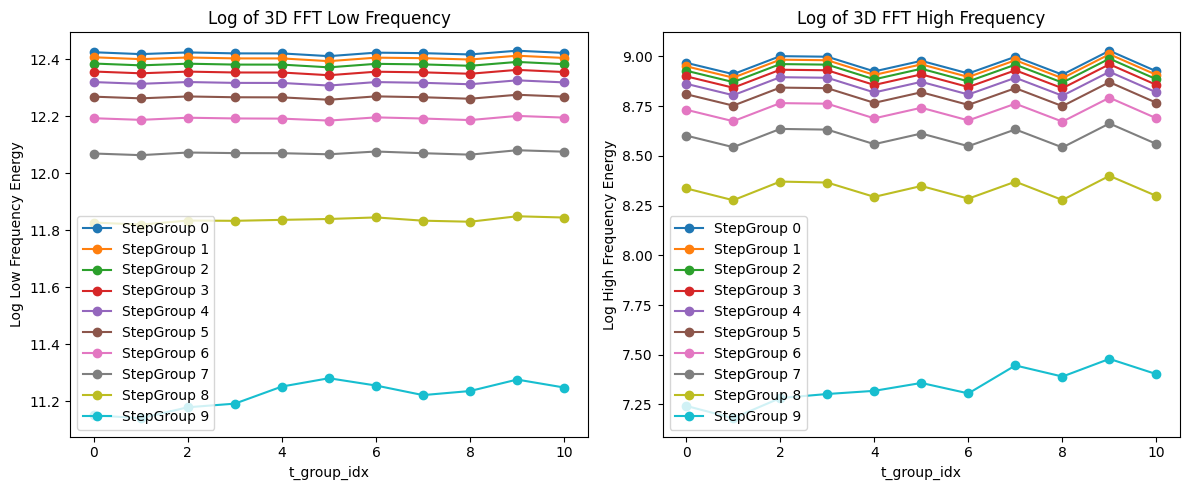


[INFO] 处理第 0 组: steps 0 ~ 4 ...

[INFO] 处理第 1 组: steps 5 ~ 9 ...

[INFO] 处理第 2 组: steps 10 ~ 14 ...

[INFO] 处理第 3 组: steps 15 ~ 19 ...

[INFO] 处理第 4 组: steps 20 ~ 24 ...

[INFO] 处理第 5 组: steps 25 ~ 29 ...

[INFO] 处理第 6 组: steps 30 ~ 34 ...

[INFO] 处理第 7 组: steps 35 ~ 39 ...

[INFO] 处理第 8 组: steps 40 ~ 44 ...

[INFO] 处理第 9 组: steps 45 ~ 49 ...


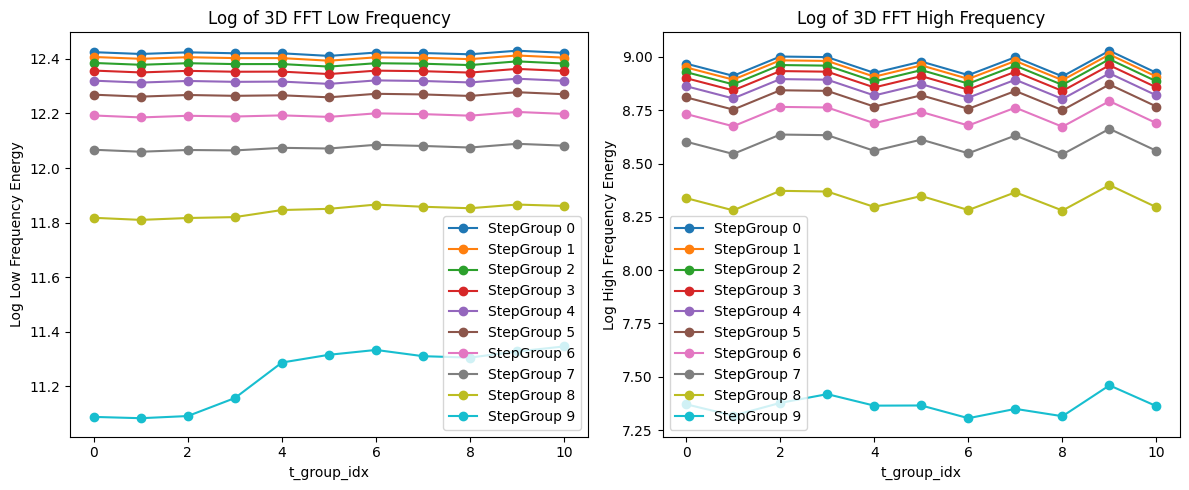


[INFO] 处理第 0 组: steps 0 ~ 4 ...

[INFO] 处理第 1 组: steps 5 ~ 9 ...

[INFO] 处理第 2 组: steps 10 ~ 14 ...

[INFO] 处理第 3 组: steps 15 ~ 19 ...

[INFO] 处理第 4 组: steps 20 ~ 24 ...

[INFO] 处理第 5 组: steps 25 ~ 29 ...

[INFO] 处理第 6 组: steps 30 ~ 34 ...

[INFO] 处理第 7 组: steps 35 ~ 39 ...

[INFO] 处理第 8 组: steps 40 ~ 44 ...

[INFO] 处理第 9 组: steps 45 ~ 49 ...


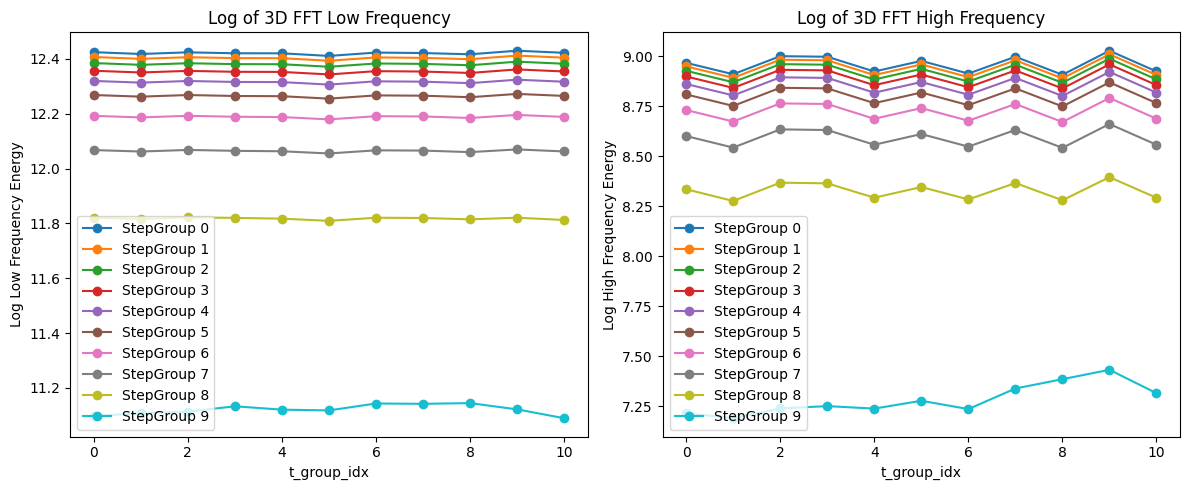

In [34]:
show_3d_freq_analysis(
    tensor_path="results/idea_0/tensor",
    steps=50,
    t_group_size=3,
    step_interval=5,
    cutoff_ratio=0.9
)
show_3d_freq_analysis(
    tensor_path="results/idea_0/tensor_1",
    steps=50,
    t_group_size=3,
    step_interval=5,
    cutoff_ratio=0.9
)
show_3d_freq_analysis(
    tensor_path="results/idea_0/tensor_2",
    steps=50,
    t_group_size=3,
    step_interval=5,
    cutoff_ratio=0.7
)

In [ ]:
import torch

# 读取 .pt 文件
file_path = "/home/siyuan/HunyuanVideo_efficiency/results/idea_0/vae/data/cyclist-15fps-360-1920x1080.pt"
data = torch.load(file_path)  # 读取 PyTorch 张量

# 检查数据结构
print("数据类型:", type(data))
print("张量形状:", data.shape)  # 确保数据维度符合 (T, H, W)
exit()
# 提取 T 维度（所有时间帧）
T_dim = data.shape[0]  # 获取时间维度大小
T_data = data[:, :, :]  # 只取 T 维度，保留 H 和 W 维度

print("提取的时间维度大小:", T_dim)
print("数据形状（T, H, W）:", T_data.shape)


/tmp/ipykernel_382692/1385115679.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)  # 读取 PyTorch 张量


数据类型: <class 'torch.Tensor'>
张量形状: torch.Size([3, 150, 480, 852])
提取的时间维度大小: 3
数据形状（T, H, W）: torch.Size([3, 150, 480, 852])


: 

In [1]:
import torch
import torch.nn.functional as F

# 读取 .pt 文件
file_path = "/home/siyuan/HunyuanVideo_efficiency/video_data/15hz_480p_tensors/catch-15fps-360-1920x1080.pt"
data = torch.load(file_path)  # 读取 PyTorch 张量

# 确保数据在 CPU 上进行缩放
data = data.cpu()

# 检查数据形状 (C, T, H, W)
print("原始数据形状:", data.shape)  # 预计 (3, 150, 480, 852)

# 目标分辨率 (240p) -> (240, new_W)
target_h = 160
aspect_ratio = data.shape[3] / data.shape[2]  # 计算宽高比
target_w = int(target_h * aspect_ratio)  # 保持原始宽高比

# 使用双线性插值缩放 (H, W) -> (240, new_W)
data_resized = F.interpolate(data, size=(target_h, target_w), mode='bilinear', align_corners=False)

# 检查缩放后的形状
print("缩放后数据形状:", data_resized[:,:129,:,:].shape)  # 预计 (3, 150, 240, new_W)

# 保存为新的 .pt 文件
output_path = "/home/siyuan/HunyuanVideo_efficiency/results/idea_0/vae/data/tensor/video_240p.pt"
torch.save(data_resized[:,:129,:,:], output_path)
print(f"已成功保存至: {output_path}")


/tmp/ipykernel_943690/2029472848.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)  # 读取 PyTorch 张量


原始数据形状: torch.Size([3, 150, 480, 852])
缩放后数据形状: torch.Size([3, 129, 160, 284])
已成功保存至: /home/siyuan/HunyuanVideo_efficiency/results/idea_0/vae/data/tensor/video_240p.pt
